In [ ]:
from datetime import timedelta
import math
import logging

from pyClarion import (Event, Agent, Priority, Input, Pool, Choice,
                       ChunkStore, BaseLevel, Family, NumDict, Atoms, Atom, Chunk, ks_crawl)


import random
from itertools import product

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import statistics as stats

NUM_CHUNKS = 18
CONSONANTS = "BCDFGHJKLMNPQRSTVWXYZ"
VOWELS = "AEIOU"
NUMBERS = "0123456789"
DELTA_T = timedelta(seconds=3)

In [1]:
class Character(Atoms):
    A: Atom
    B: Atom
    C: Atom
    D: Atom
    E: Atom
    F: Atom
    G: Atom
    H: Atom
    I: Atom
    J: Atom
    K: Atom
    L: Atom
    M: Atom
    N: Atom
    O: Atom
    P: Atom
    Q: Atom
    R: Atom
    S: Atom
    T: Atom
    U: Atom
    V: Atom
    W: Atom
    X: Atom
    Y: Atom
    Z: Atom
    _0: Atom
    _1: Atom
    _2: Atom
    _3: Atom
    _4: Atom
    _5: Atom
    _6: Atom
    _7: Atom
    _8: Atom
    _9: Atom


class IO(Atoms):
    CVC1: Atom
    CVC2: Atom
    CVC3: Atom
    NUM1: Atom
    NUM2: Atom


class PairedAssoc(Family):
    char: Character
    io: IO

NameError: name 'Atoms' is not defined

In [ ]:
class Participant(Agent):
    d: PairedAssoc
    input: Input
    store: ChunkStore
    blas: BaseLevel
    pool: Pool
    choice: Choice

    def __init__(self, name: str, scale, decay, sd, blw) -> None:
        p = Family()
        e = Family()
        d = PairedAssoc()
        super().__init__(name, p=p, e=e, d=d)
        self.d = d
        with self:
            self.input = Input("input", (d, d))
            self.store = ChunkStore("store", d, d, d)
            self.blas = BaseLevel(
                "blas", p, e, self.store.chunks, sc=scale, de=decay, unit=timedelta(milliseconds=1))
            self.pool = Pool("pool", p, self.store.chunks, func=NumDict.sum)
            self.choice = Choice("choice", p, self.store.chunks, sd=sd)
        self.store.bu.input = self.input.main
        self.blas.input = self.choice.main
        self.pool["store.bu"] = (
            self.store.bu.main,
            lambda d: d.shift(x=1).scale(x=0.5).logit())
        self.pool["blas"] = (
            self.blas.main,
            lambda d: d.bound_min(x=1e-8).log().with_default(c=0.0))
        self.choice.input = self.pool.main
        with self.pool.params[0].mutable():
            self.pool.params[0][~self.pool.p["blas"]] = blw
        self.blas.ignore.add(~self.store.chunks.nil)

    def resolve(self, event: Event) -> None:
        if event.source == self.store.bu.update:
            self.blas.update()
        if event.source == self.blas.update:
            self.choice.trigger()

    def start_trial(self,
                    dt: timedelta,
                    priority: Priority = Priority.PROPAGATION
                    ) -> None:
        self.system.schedule(self.start_trial, dt=dt, priority=priority)

    def finish_trial(self,
                     dt: timedelta,
                     priority: Priority = Priority.PROPAGATION
                     ) -> None:
        self.system.schedule(self.finish_trial, dt=dt, priority=priority)

In [ ]:
def init_stimuli(d: PairedAssoc, l: list[str]) -> list[tuple[Chunk, Chunk]]:
    io, char = d.io, d.char
    return [
        (s ^
         (query :=
          s[:3] ^
          + io.CVC1 ** char[s[0]]
          + io.CVC2 ** char[s[1]]
          + io.CVC3 ** char[s[2]])
         + io.NUM1 ** char[f"_{s[4]}"]
         + io.NUM2 ** char[f"_{s[5]}"],
         query)
        for s in l]

In [ ]:
def generate_cvc_list(n):
    items = []
    visited = set()
    for _ in range(n):
        c1 = random.choice(CONSONANTS)
        c2 = random.choice(VOWELS)
        c3 = random.choice(CONSONANTS)
        num1 = random.choice(NUMBERS)
        num2 = random.choice(NUMBERS)

        while c1 + c2 + c3 in visited or num1 + num2 in visited:
            c1 = random.choice(CONSONANTS)
            c2 = random.choice(VOWELS)
            c3 = random.choice(CONSONANTS)
            num1 = random.choice(NUMBERS)
            num2 = random.choice(NUMBERS)

        visited.add(c1 + c2 + c3)
        visited.add(num1 + num2)
        items.append(f"{c1}{c2}{c3}_{num1}{num2}")
    return items

In [ ]:
std_chunks = generate_cvc_list(NUM_CHUNKS)

def simulate(scale, decay, sd, blw):
    participant = Participant("participant", scale, decay, sd, blw)
    stimuli = init_stimuli(
        participant.d, std_chunks)
    indices = list(range(len(stimuli))) * 2
    random.shuffle(indices)
    presentations = {}
    trial = 0
    results = {
        "trial": [],
        "stim": [],
        "time": [],
        "delta": [],
        "response": [],
        "correct": [],
        "strength": [],
        "rt": [],
        "decay": [],
        "scale": [],
    }
    participant.start_trial(timedelta())
    while participant.system.queue:
        event = participant.system.advance()
        # print(event.describe())
        if event.source == participant.start_trial:
            i = indices[trial]
            study, test = stimuli[i]
            if i not in presentations:
                participant.store.compile(study)
            else:
                participant.input.send(test)
            participant.finish_trial(DELTA_T)
        if event.source == participant.finish_trial:
            i = indices[trial]
            if i in presentations:
                target, _ = stimuli[i]
                time = participant.system.clock.time / timedelta(seconds=1)
                response_key = participant.choice.poll()[
                    ~participant.store.chunks]
                response_chunk = ks_crawl(
                    participant.system.root, response_key)
                results["trial"].append(trial)
                results["stim"].append(target._name_)
                results["time"].append(time)
                results["delta"].append(3 * (trial - presentations[i]))
                results["response"].append(
                    response_chunk._name_)  # type: ignore
                results["correct"].append(response_chunk == target)
                results["strength"].append(
                    participant.choice.sample[0][response_key])
                results["rt"].append(
                    math.exp(-participant.choice.sample[0][response_key]))
                results["decay"].append(decay)
                results["scale"].append(scale)
            else:
                presentations[i] = trial
            if trial < 2 * len(stimuli) - 1:
                participant.start_trial(DELTA_T)
                trial += 1
    print(f"Completed simulation with {np.mean(results["correct"])}.")
    return results

In [ ]:
scales = [2]
decays = [0.4, 0.6] * 10000
sds = [0.45]
blw = [0.1]

In [ ]:
results = []

for scale, decay, sd, b in product(scales, decays, sds, blw):
    results.append(simulate(scale, decay, sd, b))
results_df = pd.concat([pd.DataFrame(r) for r in results])

Completed simulation with 0.4666666666666667.
Completed simulation with 0.4.
Completed simulation with 0.5.
Completed simulation with 0.5666666666666667.
Completed simulation with 0.5333333333333333.
Completed simulation with 0.5666666666666667.
Completed simulation with 0.6666666666666666.
Completed simulation with 0.4666666666666667.
Completed simulation with 0.5666666666666667.
Completed simulation with 0.5666666666666667.
Completed simulation with 0.4666666666666667.
Completed simulation with 0.43333333333333335.
Completed simulation with 0.5666666666666667.
Completed simulation with 0.4.
Completed simulation with 0.4.
Completed simulation with 0.4.
Completed simulation with 0.43333333333333335.
Completed simulation with 0.4666666666666667.
Completed simulation with 0.36666666666666664.
Completed simulation with 0.6333333333333333.
Completed simulation with 0.4666666666666667.
Completed simulation with 0.5666666666666667.
Completed simulation with 0.36666666666666664.
Completed sim

KeyboardInterrupt: 

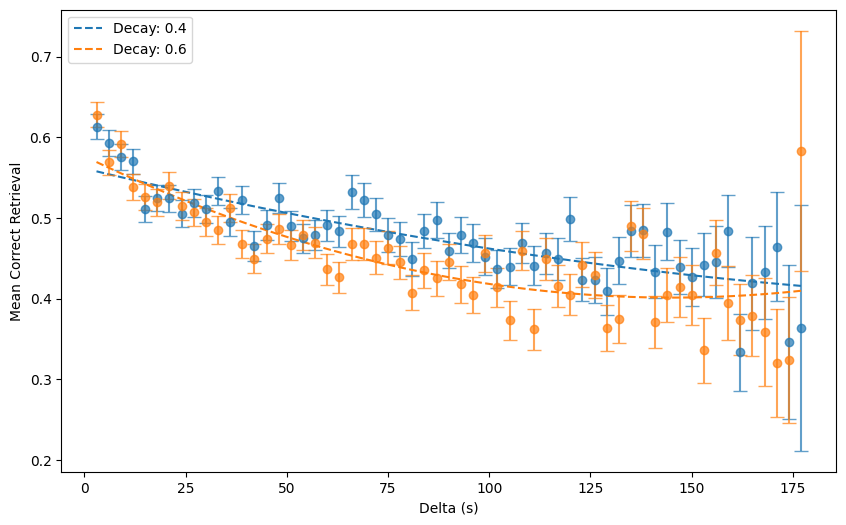

In [ ]:
""" Plot Mean Correct Retrieval vs Delta (Interval between study and test). """
def mean_delta_plot(df):
    plt.figure(figsize=(10, 6))
    
    delta_data = df.groupby(["delta", "decay"])["correct"].agg(["mean", "std", "sem"]).reset_index()
    delta_data = delta_data[(delta_data["mean"] > 0) & (delta_data["mean"] < 1)]
    # delta_data["mean"] = delta_data["mean"].apply(lambda p: p / (1 - p))
    cmap = {v: i for i, v in enumerate(delta_data["decay"].unique())}
    grp = delta_data.groupby("decay")

    for decay, grpd in grp:
        plt.errorbar(grpd["delta"], grpd["mean"], yerr=grpd["sem"], color=f"C{cmap[decay]}", fmt='o', alpha=.7, capsize=5)
        # m, b = np.polyfit(grpd["delta"], grpd["mean"], 1)
        # plt.plot(grpd["delta"], [m*x + b for x in grpd["delta"]],
        #          color=f"C{cmap[decay]}", label=f"Decay: {decay}")
        x = grpd["delta"]
        y = grpd["mean"]

        degree = 2
        coefficients = np.polyfit(x, y, degree)
        polynomial = np.poly1d(coefficients)

        x_curve = np.linspace(x.min(), x.max(), 100)
        y_curve = polynomial(x_curve)
        
        plt.plot(x_curve, y_curve, color=f"C{cmap[decay]}", linestyle='dashed', label=f"Decay: {decay}")

    # plt.title("Mean Correct Retrieval vs Delta (Interval between study and test)")
    plt.xlabel("Delta (s)")
    plt.ylabel("Mean Correct Retrieval")
    plt.legend()
    plt.show()

mean_delta_plot(results_df)

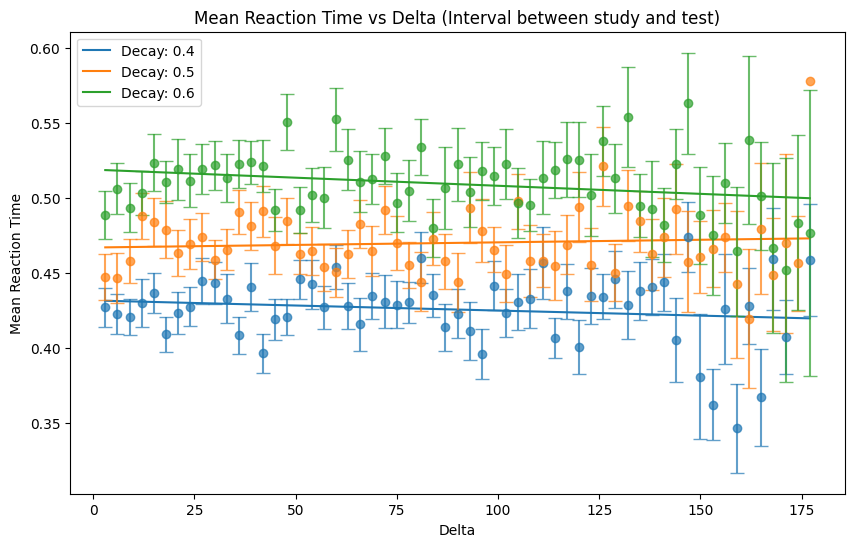

In [ ]:
""" Plot Mean Reaction Time vs Delta (Interval between study and test). """
def mean_rt_plot(df):
    plt.figure(figsize=(10, 6))
    
    delta_data = df.groupby(["delta", "decay"])["rt"].agg(["mean", "std", "sem"]).reset_index()
    cmap = {v: i for i, v in enumerate(delta_data["decay"].unique())}
    grp = delta_data.groupby("decay")
    for decay, grpd in grp:
        plt.errorbar(grpd["delta"], grpd["mean"], yerr=grpd["sem"], color=f"C{cmap[decay]}", fmt='o', alpha=.7, capsize=5)
        m, b = np.polyfit(grpd["delta"], grpd["mean"], 1)
        plt.plot(grpd["delta"], [m*x + b for x in grpd["delta"]],
                 color=f"C{cmap[decay]}", label=f"Decay: {decay}")

    plt.title("Mean Reaction Time vs Delta (Interval between study and test)")
    plt.xlabel("Delta")
    plt.ylabel("Mean Reaction Time")
    plt.legend()
    plt.show()

mean_rt_plot(results_df)